In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from sklearn.manifold import TSNE
# customized lib
import measures

np.random.seed(0)

In [2]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df = df.loc[400:1400] # first 1000 segments
df = df.reset_index().drop('index', axis=1)
df

,segment,label
0,obstin bigot offici set defianc liber initi go...,c
1,ask thing and proper repli must given It said ...,c
2,co-oper attempt dethron but influenc act parli...,c
3,busi necessari parliament elect execut cours f...,c
4,behind treasuri bench nay possibl rise man sit...,c
...,...,...
995,lamb chop fri tomato potato la crãªme rais bis...,g
996,glass rhine wine IV glass water V glass champa...,g
997,cover cloth set away cool place hour dinner ti...,g
998,transpar veil egg cook white firm lift griddl ...,g


In [4]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

documents = df['segment'].tolist()

doc_tokenized = [simple_preprocess(doc, min_len=1, max_len=2000) for doc in documents]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

,topic,score
0,2,0.000000
1,3,0.000000
2,4,-0.399923
3,5,0.000000
4,6,-0.266615
5,7,-0.228527
6,8,0.000000
7,9,-0.177743


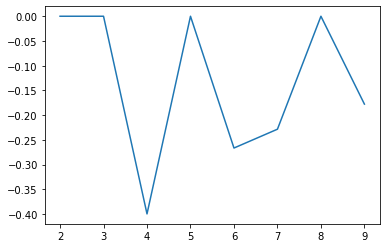

In [5]:
measures.best_num_topic(corpus_tfidf, dictionary ,10)

Peak at k=5, silhouette_score = 0.5840678969255102


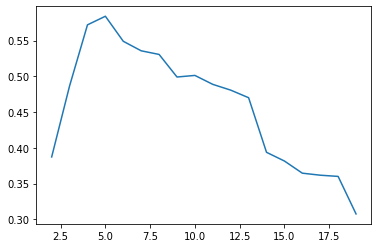

In [6]:
results = measures.best_silhouette_score(AgglomerativeClustering(), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

In [7]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=best_at)
corpus_lsi = lsi_model[corpus_tfidf] 
cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()

0.0

In [8]:
def get_pred_map(pred):
    pred_map = dict()
    for i in range(0, k):
        count = np.bincount(pred[i * 200 : i * 200 + 200])
        np.ndarray.resize(count, (1,k))
        count = count[0]
        index = np.where(count == max(count))[0][0]
        label = chr(ord('c')+i)
        pred_map[index] = label
        print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

    mapped_pred = []
    for ele in pred_ward:
        mapped_pred.append(pred_map[ele])
    mapped_pred = np.asarray(mapped_pred) # predicted label
    return mapped_pred

In [9]:
def plot_cluster(corpus, pred):
    tfidf_embedded = TSNE(n_components=2, 
                        perplexity=50, 
                        learning_rate = 'auto',
                        n_iter=1000, 
                        random_state=0).fit_transform(corpus)

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes()
    plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = pred)
    plt.show()

Linkage ward

c:[  0   0 196   0   4]	c mapped to 2
d:[  0   0   2   3 195]	d mapped to 4
e:[  5   0   0 195   0]	e mapped to 3
f:[197   0   0   0   3]	f mapped to 0
g:[  0 198   0   2   0]	g mapped to 1


C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


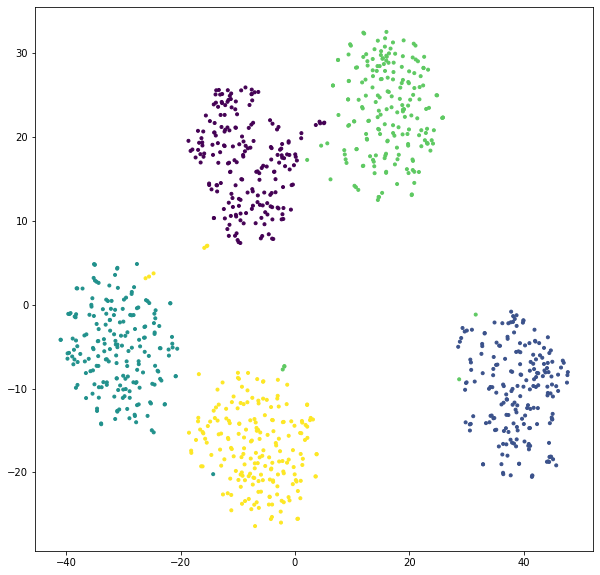

In [10]:
from gensim.matutils import corpus2csc
k = 5
corpus_tfidf_sparse = corpus2csc(corpus_tfidf).T
pred_ward = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(corpus_tfidf_sparse.toarray())

mapped_pred_ward = get_pred_map(pred_ward)
plot_cluster(corpus_tfidf_sparse, pred_ward)

In [11]:
kappa = measures.get_kappa(df['label'], mapped_pred_ward)
rand_score = measures.get_rand_score(df['label'], mapped_pred_ward)
silhouette = measures.get_silhouette_score(corpus_lsi, pred_ward)
coherence = measures.get_coherence(cm)

kappa: 0.97625
rand score: 0.9531764266817871
silhouette score: 0.5194243213629274
coherence: 0.0


Linkage average

Peak at k=5, silhouette_score = 0.5882247836792647


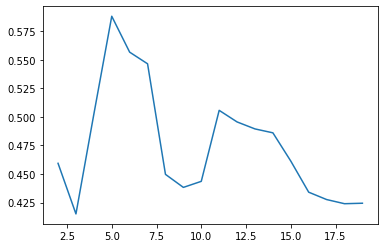

In [14]:
results = measures.best_silhouette_score(AgglomerativeClustering(linkage="average"), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


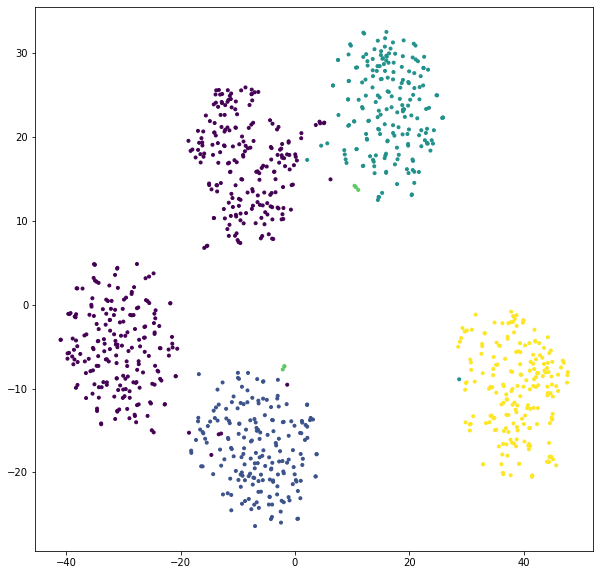

In [15]:
pred_avg = AgglomerativeClustering(n_clusters=best_at, linkage="average").fit_predict(corpus_tfidf_sparse.toarray())

plot_cluster(corpus_tfidf_sparse, pred_avg)

Linkage complete

Peak at k=5, silhouette_score = 0.5344924229755618


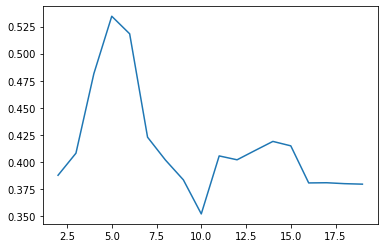

In [16]:
results = measures.best_silhouette_score(AgglomerativeClustering(linkage="complete"), corpus = corpus_tfidf, dictionary = dictionary, max_n_clusters = 20, best_num_topic=5)
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


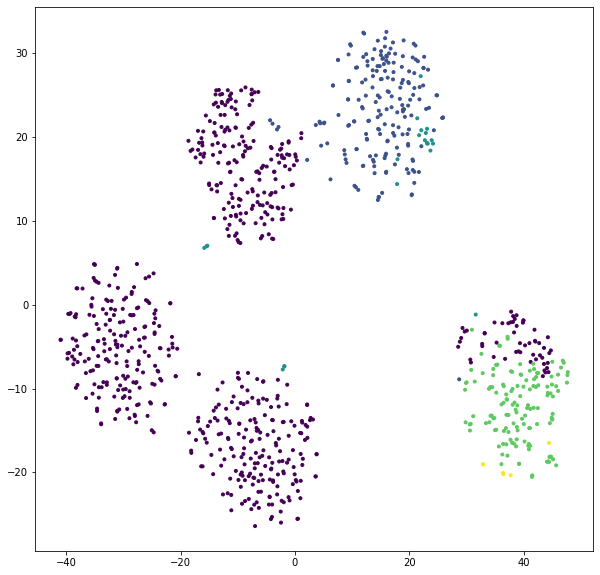

In [17]:
pred_comp = AgglomerativeClustering(n_clusters=best_at, linkage="complete").fit_predict(corpus_tfidf_sparse.toarray())

plot_cluster(corpus_tfidf_sparse, pred_comp)